# CPSC 368 Impact By Disease (KNM Neighbours)

In [1]:
import oracledb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display

In [2]:
# INPUT USER INFO HERE
CWL = "nick2003"
studentnum = "45695970"

In [3]:
# Simple test run
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user=f"ora_{CWL}", password=f"a{studentnum}", dsn=dsn)
cur = connection.cursor()

try:
    # SQL code
    cur.execute(
        """
        SELECT 
            us.LocationDesc AS State,
            CASE 
                WHEN us.DataValueUnit = 'cases per 100,000' THEN 'per 100,000'
                ELSE us.DataValueUnit 
            END AS DeathRateUnit,
            us.DataValueType AS DeathRateType,
            us.AvgDataValue AS AvgDeathRate,
            us.Stratification1,
            us.Question,
            us.DataValue,
            us.Topic AS Disease,
            kff.All_Uninsured
        FROM USCDI us
        LEFT JOIN KFF2019_new kff
            ON us.LocationDesc = kff.Location
        WHERE us.LocationDesc IN ('Texas', 'Massachusetts')
            AND us.Topic IN ('Cardiovascular Disease', 'Cancer')
            AND us.DataValueUnit IN ('cases per 100,000', 'per 100,000')
            AND us.DataValueType = 'Crude Rate'
            AND us.Stratification1 = 'Overall'
            AND us.Has2019 = 1
        """
    )
    
    # Fetch SELECT results 
    rows = cur.fetchall()
    
    # Get column names from cursor
    columns = [desc[0] for desc in cur.description]
    
    # Create DataFrame
    USCDI_final = pd.DataFrame(rows, columns=columns)
    
    print("Completed dataframe.")
except Exception as e:
    print(f"Error executing SQL query: {e}")
finally: 
    cur.close()
    connection.close()

Completed dataframe.


In [4]:
# USCDI = pd.read_csv('final_datasets_V1/cleaned/USCDI.csv')
# KFF2019_new = pd.read_csv("final_datasets_V1/cleaned/KFF2019_new.csv")

In [5]:
# print("DataFrame shape:", USCDI.shape)

In [6]:
USCDI_final

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,QUESTION,DATAVALUE,DISEASE,ALL_UNINSURED
0,Massachusetts,"per 100,000",Crude Rate,114.72,Overall,"Invasive cancer (all sites combined), incidence",573.6,Cancer,0.044
1,Massachusetts,"per 100,000",Crude Rate,9.00,Overall,Lung and bronchial cancer mortality among all ...,45.0,Cancer,0.044
2,Texas,"per 100,000",Crude Rate,4.22,Overall,"Breast cancer mortality among all females, und...",21.1,Cancer,0.245
3,Texas,"per 100,000",Crude Rate,84.74,Overall,"Invasive cancer (all sites combined), incidence",423.7,Cancer,0.245
4,Texas,"per 100,000",Crude Rate,6.36,Overall,Lung and bronchial cancer mortality among all ...,31.8,Cancer,0.245
5,Massachusetts,"per 100,000",Crude Rate,2.80,Overall,Colon and rectum (colorectal) cancer mortality...,14.0,Cancer,0.044
6,Massachusetts,"per 100,000",Crude Rate,8.68,Overall,Lung and bronchial cancer mortality among all ...,43.4,Cancer,0.044
7,Massachusetts,"per 100,000",Crude Rate,112.32,Overall,"Invasive cancer (all sites combined), incidence",561.6,Cancer,0.044
8,Massachusetts,"per 100,000",Crude Rate,0.28,Overall,"Cervical cancer mortality among all females, u...",1.4,Cancer,0.044
9,Massachusetts,"per 100,000",Crude Rate,36.80,Overall,Invasive cancer (all sites combined) mortality...,184.0,Cancer,0.044


After reading the data file, we see that it contains 309,215 observations and 13 attributes. Further analysis, including checking for missing values, will be conducted later, as filtering needs to be applied to finalize the dataset.

In [7]:
# USCDI['DataValueUnit'] = USCDI['DataValueUnit'].replace({'cases per 100,000': 'per 100,000'})

In [8]:
# USCDI_filter1 = USCDI[
#     (USCDI['LocationDesc'].isin(['Texas', 'Massachusetts'])) &
#     (USCDI['Topic'].isin(['Cardiovascular Disease', 'Cancer'])) &
#     (USCDI['DataValueUnit'] == "per 100,000")&
#     (USCDI['DataValueType'] == "Crude Rate") &
#     (USCDI['Stratification1'] == "Overall") &
#     (USCDI["Has2019"] == 1)
# ]

In [9]:
# USCDI_filter2 = USCDI_filter1[['DataValue','Stratification1','QUESTION','LocationDesc', 'Topic', 'DataValueUnit','DataValueType', 'AvgDataValue']]
# USCDI_final = pd.merge(USCDI_filter2, KFF2019_new[['Location', 'All_Uninsured']], 
#                      left_on='LocationDesc', right_on='Location', how='left')
# USCDI_final.drop(columns='Location', inplace=True)
# USCDI_final.rename(columns={'AvgDataValue': 'AVGDEATHRATE'}, inplace=True)
# USCDI_final.rename(columns={'DataValueType': 'DeathRateType'}, inplace=True)
# USCDI_final.rename(columns={'DataValueUnit': 'DeathRateUnit'}, inplace=True)
# USCDI_final.rename(columns={'Topic': 'DISEASE'}, inplace = True)
# USCDI_final.rename(columns={'LocationDesc': 'STATE'}, inplace = True)

In [10]:
USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Cervical cancer mortality among all females, underlying cause': 
     'Cervical cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Invasive cancer (all sites combined) mortality among all people, underlying cause': 
     'Invasive cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Breast cancer mortality among all females, underlying cause': 
     'Breast cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Colon and rectum (colorectal) cancer mortality among all people, underlying cause': 
     'Colorectal cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Lung and bronchial cancer mortality among all people, underlying cause': 
     'Lung cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Prostate cancer mortality among all males, underlying cause': 
     'Prostate cancer'})

USCDI_final['QUESTION'] = USCDI_final['QUESTION'].replace(
    {'Coronary heart disease mortality among all people, underlying cause': 
     'Coronary heart disease'})

USCDI_final = USCDI_final[USCDI_final['QUESTION'].isin(['Cervical cancer', 'Breast cancer',
                                                        'Colorectal cancer', 'Prostate cancer',
                                                       'Lung cancer', 'Coronary heart disease'])]

USCDI_final.rename(columns={'QUESTION': 'TYPE'}, inplace=True)

/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_91281/3019104171.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USCDI_final.rename(columns={'QUESTION': 'TYPE'}, inplace=True)


We selected the necessary attributes to answer this question specifically and renamed some attributes for clarity. Note that we excluded invasive cancer because it is too broad—it includes many different types of "invasive" cancer, making it unsuitable for analyzing the impact of specific cancer types.

In [11]:
USCDI_final.isnull().sum()

STATE              0
DEATHRATEUNIT      0
DEATHRATETYPE      0
AVGDEATHRATE       0
STRATIFICATION1    0
TYPE               0
DATAVALUE          0
DISEASE            0
ALL_UNINSURED      0
dtype: int64

The attributes needed does not contain missing values, therefore imputation is unnecessary.

In [12]:
CHD = USCDI_final[
    (USCDI_final['DISEASE'] == "Cardiovascular Disease")]

CANCER = USCDI_final[USCDI_final['DISEASE'] == "Cancer"]

Since we are examining coronary heart disease and cancer, the dataset is divided into two subsets.

In [13]:
USCDI_final.head()

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,TYPE,DATAVALUE,DISEASE,ALL_UNINSURED
1,Massachusetts,"per 100,000",Crude Rate,9.00,Overall,Lung cancer,45.0,Cancer,0.044
2,Texas,"per 100,000",Crude Rate,4.22,Overall,Breast cancer,21.1,Cancer,0.245
4,Texas,"per 100,000",Crude Rate,6.36,Overall,Lung cancer,31.8,Cancer,0.245
5,Massachusetts,"per 100,000",Crude Rate,2.80,Overall,Colorectal cancer,14.0,Cancer,0.044
6,Massachusetts,"per 100,000",Crude Rate,8.68,Overall,Lung cancer,43.4,Cancer,0.044


In [14]:
CHD

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,TYPE,DATAVALUE,DISEASE,ALL_UNINSURED
30,Massachusetts,"per 100,000",Crude Rate,84.0,Overall,Coronary heart disease,84.0,Cardiovascular Disease,0.044
32,Texas,"per 100,000",Crude Rate,88.3,Overall,Coronary heart disease,88.3,Cardiovascular Disease,0.245


In [15]:
CANCER

,STATE,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,TYPE,DATAVALUE,DISEASE,ALL_UNINSURED
1,Massachusetts,"per 100,000",Crude Rate,9.00,Overall,Lung cancer,45.0,Cancer,0.044
2,Texas,"per 100,000",Crude Rate,4.22,Overall,Breast cancer,21.1,Cancer,0.245
4,Texas,"per 100,000",Crude Rate,6.36,Overall,Lung cancer,31.8,Cancer,0.245
5,Massachusetts,"per 100,000",Crude Rate,2.80,Overall,Colorectal cancer,14.0,Cancer,0.044
6,Massachusetts,"per 100,000",Crude Rate,8.68,Overall,Lung cancer,43.4,Cancer,0.044
8,Massachusetts,"per 100,000",Crude Rate,0.28,Overall,Cervical cancer,1.4,Cancer,0.044
11,Massachusetts,"per 100,000",Crude Rate,4.56,Overall,Breast cancer,22.8,Cancer,0.044
12,Massachusetts,"per 100,000",Crude Rate,0.28,Overall,Cervical cancer,1.4,Cancer,0.044
13,Texas,"per 100,000",Crude Rate,0.58,Overall,Cervical cancer,2.9,Cancer,0.245
14,Massachusetts,"per 100,000",Crude Rate,4.54,Overall,Breast cancer,22.7,Cancer,0.044


In terms of outliers, it is not necessary since we do not have a lot of observations. Therefore in order to maintain information, outlier detection and removal is ignored. 

A summary table for different types of cancer with descriptive statistics is provided for both states.

In [16]:
CANCER.groupby(["STATE","TYPE"])["AVGDEATHRATE"].agg(["mean","std","min","max","count"])

mean       std   min   max  count
STATE         TYPE                                                
Massachusetts Breast cancer      4.55  0.014142  4.54  4.56      2
              Cervical cancer    0.28  0.000000  0.28  0.28      2
              Colorectal cancer  2.82  0.028284  2.80  2.84      2
              Lung cancer        8.84  0.226274  8.68  9.00      2
              Prostate cancer    3.86  0.056569  3.82  3.90      2
Texas         Breast cancer      4.22  0.000000  4.22  4.22      2
              Cervical cancer    0.58  0.000000  0.58  0.58      2
              Colorectal cancer  2.74  0.000000  2.74  2.74      2
              Lung cancer        6.29  0.098995  6.22  6.36      2
              Prostate cancer    2.77  0.042426  2.74  2.80      2

## Visualizations

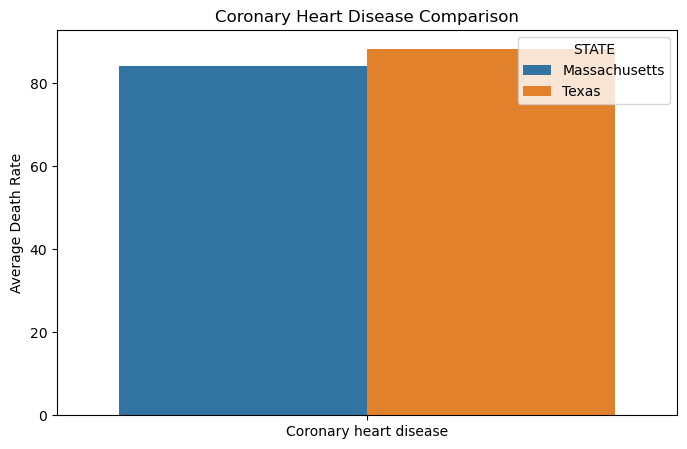

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(data= CHD, x='TYPE', y='AVGDEATHRATE', hue='STATE')
plt.xlabel('')
plt.ylabel('Average Death Rate')
plt.title('Coronary Heart Disease Comparison')
plt.legend(title='STATE')
plt.show()

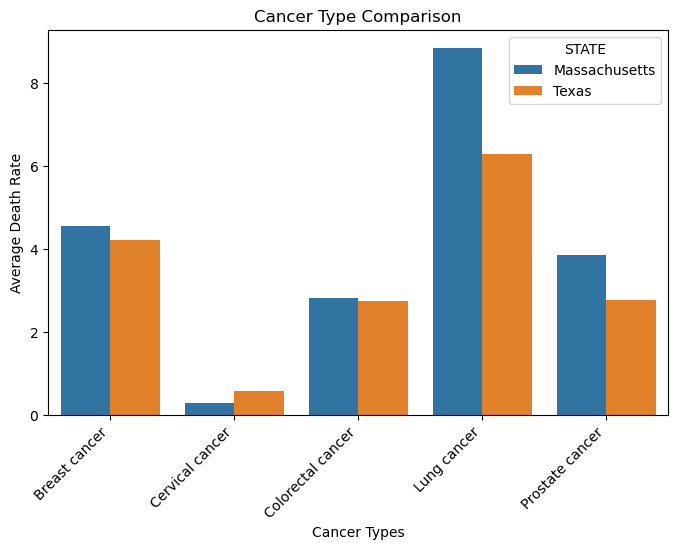

In [18]:
eda_summary_cancer = CANCER.groupby(['STATE', 'TYPE'])['AVGDEATHRATE'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=eda_summary_cancer, x='TYPE', y='AVGDEATHRATE', hue='STATE')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Types')
plt.ylabel('Average Death Rate')
plt.title('Cancer Type Comparison')
plt.legend(title='STATE')
plt.show()